### PPO actor-critic Frozen Lake

Based on arxiv1707.06347v2 paper. 
PPO is a policy-gradient method, these methods use gradient ascent to maximize the objective function.
based on actor-critic method using 2 networks.

To calculate Actor loss:

step1 : define the probability ratio among the old and the new policy.
$$ \frac {{\pi_\theta(a|s)}}{\pi_{\theta_{old}(a|s)}} $$    
    
Ensuring that a new update of the policy does not change it too much from the previous policy.

step2: using this ratio we can define the objective function:
$$ L^{Naive}(\theta) = E[r(\theta)Â_{\theta_{old}}(s|a)] $$    

Where Â is the advantage function, there are some options for the advantage function (The paper High-Dimensional Continuous Control Using Generalized Advantage Estimation lists several functions -https://arxiv.org/abs/1506.02438). 
In this case we're using the GAE (generalizaed advantage function)

$$ Â_t = \delta_{t} + (\gamma \lambda) \delta_{t+1}+ ... + (\gamma \lambda)^{T-t+1} \delta_{T-1} $$
where  $\delta_{t} = r_t + \gamma V(s_{t+1}) - V(s_t)$
        

step3: However, the naive objective function $ L^{Naive}(\theta) $ can be unstable when the action selection probability is low with the old policy, since $ r(\theta) $ is high, making the updates extremely large.

with PPO-Clip we clip the probability ratio to constrain the size of the update. The ratio is constrained to be between some interval :$ (1−\epsilon,1+\epsilon)$ where $\epsilon $ is a clipping hyperparameter. 
Then, the objective function becomes:
$$ L{clip} = E[min(r(\theta)Â\theta_{old}(s,a) , clip(r(\theta), (1-\epsilon, 1+\epsilon) Â\theta_{old}(s,a))]$$

step 4: Finally, we add an entropy term to encourage exploration and with -1 apply the gradient ascent.

To calculate Critic loss:

Step5: For the critic network, we seek to minimize the difference between the estimated value and the actual value. Using the squared loss, we get another objective function $L^{VF}(\theta)$.

$$L^{VF}(\theta) = (V_{\theta} - V_{target})² $$

applying gradient descent








In [71]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import gym


In [72]:
def to_onehot(size,value):
  my_onehot = np.zeros((size))
  my_onehot[value] = 1.0
  return my_onehot

In [73]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = [] 
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []
        
        self.batch_size = batch_size
        
    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        #stochastic of the mini batch, stochastic gradient ascent
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]
        
        return np.array(self.states), np.array(self.actions), np.array(self.probs), np.array(self.vals),\
               np.array(self.rewards), np.array(self.dones), batches    
    
    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)
        
        
    def clear_memory(self):    
        #clear the memory at the end of every trajectory
        self.states = []
        self.probs = [] 
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []
        

In [74]:
class ActorNetwork(nn.Module):
    def __init__(self, input_dims, n_actions, alpha, fc1_dims=64, fc2_dims=64, chkpt_dir='tmp/ppo'):                
        super(ActorNetwork, self).__init__()
        
        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
                        nn.Linear(input_dims, fc1_dims),                        
                        nn.ReLU(),
                        #nn.Linear(fc1_dims, fc2_dims),
                        #nn.ReLU(),
                        nn.Linear(fc1_dims, n_actions),
                        nn.Softmax(dim=-1) #with softmax we'll get sum of probabilities equal to 1            
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        #we're calculating the series of probabilities that we're going to use to draw from a distribution to get 
        #our actual action and then we can use that to get the log probabilities for the calculation of the ratio 
        #for the 2 probabilities in our update for our learning function
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist
    
    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))
        
        

In [75]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=64, fc2_dims=64, chkpt_dir='tmp/ppo'):
        super(CriticNetwork, self).__init__()
        
        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Linear(input_dims, fc1_dims),                
                nn.ReLU(),
                #nn.Linear(fc1_dims, fc2_dims),
                #nn.ReLU(),
                nn.Linear(fc1_dims, 1)
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        value = self.critic(state)
        
        return value
    
    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))
        

In [76]:
class Agent:
    
    def __init__(self, n_actions, input_dims, alpha=0.01, gamma=0.9, gae_lambda=0.95, 
                 policy_clip=0.1, batch_size=64, N=2048, n_epochs=10):        
        #N steps before we preform an update        
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda       
        self.entropyCoefficient = 0.0001
                
        self.critic = CriticNetwork(input_dims=input_dims, alpha=alpha)
        self.actor = ActorNetwork(input_dims=input_dims, n_actions=n_actions, alpha=alpha)
        self.memory = PPOMemory(batch_size)
        
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)
        
    def save_models(self):
        print("saving models")
        self.actor.save_checkpoint()        
        self.critic.save_checkpoint()
        
    def load_models(self):
        print("Loading models")
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()
        
        
    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        
        #distribution to choose an action
        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()
        
        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()
        
        return action, probs, value
    
    def learn(self):
        #following the bellow cell formula 
        
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr, reward_arr, dones_arr, batches = \
            self.memory.generate_batches()                                          
            
            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)
            
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*(1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                    
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)
            values = T.tensor(values).to(self.actor.device)
            
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                #old probs got by old actor
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)
                
                #compute the probability ratio
                #to get the pi theta old  and  pi theta new, and calculate the new probs
                #get the old probs with the new actor and old states
                dist = self.actor(states)                                
                
                new_probs = dist.log_prob(actions)                
                prob_ratio = (new_probs - old_probs).exp()
                
                #Compute the PPO loss
                
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip, 1+self.policy_clip)*advantage[batch]
                weighted_clipped_probs = weighted_clipped_probs + (self.entropyCoefficient * dist.entropy())
                
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()
                returns = advantage[batch] + values[batch]
                
                
                #get the updated value of the critic network
                critic_value = self.critic(states)                
                critic_value = T.squeeze(critic_value)
                
                critic_loss = 0.5*((returns - critic_value)**2)
                critic_loss = critic_loss.mean()
                #critic_loss = float(huber_loss(returns, critic_value))
                
                #total_loss = actor_loss + 0.5*critic_loss                
                self.actor.optimizer.zero_grad()
                actor_loss.backward()
                self.actor.optimizer.step()
                
                self.critic.optimizer.zero_grad()
                critic_loss.backward()                
                self.critic.optimizer.step()
                
        self.memory.clear_memory()
                
                
                
                
        

In [77]:
env = gym.make('FrozenLake-v0', is_slippery=False)

N = 10
batch_size = 5
n_epochs = 10
alpha = 0.0003
n_games = 1500
num_inputs = env.observation_space.n
num_outputs = env.action_space.n
seed = 42
env.seed(seed)


[42]

This is the main loop. For each game (episode) 
we reset the environmet and until the game finish (the agent falls in a hole or achieves the goal) we collect the 
experience in a buffer and collect the rewards.
After N steps (or if we win the game) the actor and the critic model learn applying the steps defined previously.
Due the rewards in FL are always 0 and they only change to 1 when the agent reaches the goal, the agent could execute 
always the same iterations with rewards 0. It needs a motivation to move and learn, so if during 6 steps 
the agent always go the same state we'd applied a little negative reward.
And when the agent reach the objective, we'd applied a little positive reward and learn this trajectory.
Due to we apply an entropy to keep the exploration the agent would not have overfitting.
In fact we demostrate it in the different trajectroies used to get the goal.

In [78]:
agent = Agent(n_actions=env.action_space.n, input_dims=env.observation_space.n, 
              batch_size=batch_size, alpha=alpha, n_epochs=n_epochs)


games_history = []
score_history = []
rewards_acum = []

learn_iters = 0
n_steps = 0
total_rewards = 0
repetidos = 0

for i in range(n_games):
    observation = env.reset()
    observation = to_onehot(num_inputs ,observation).reshape(1, num_inputs)
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        observation_ = to_onehot(num_inputs ,observation_).reshape(1, num_inputs)
        
        #pequeño incentivo para que se mueva
        if np.array_equal(observation_, observation):        
            repetidos += 1
            
        if (repetidos ==6) and (reward <= 0.0):    
            reward = -0.1 
            repetidos = 0        
        
        if reward >= 1.0:
            reward += 0.1
            agent.learn()
            learn_iters += 1
        
        n_steps += 1
        score += reward
        total_rewards += reward       
                    
        agent.remember(observation, action, prob, val, reward, done)
        
        if n_steps % N ==0:            
            agent.learn()
            learn_iters += 1
        observation = observation_
        
        
    score_history.append([i, reward])
    games_history.append(i)
    rewards_acum.append(total_rewards)              
    print('episode', i, 'reward %.1f' %reward, 'score %.1f' %score, 'regards total %.1f' %total_rewards, 'time_steps', n_steps, 'learning_steps', learn_iters)    


episode 0 reward 0.0 score 0.0 regards total 0.0 time_steps 3 learning_steps 0
episode 1 reward 0.0 score 0.0 regards total 0.0 time_steps 7 learning_steps 0
episode 2 reward 0.0 score 0.0 regards total 0.0 time_steps 9 learning_steps 0
episode 3 reward 0.0 score 0.0 regards total 0.0 time_steps 15 learning_steps 1
episode 4 reward 0.0 score -0.1 regards total -0.1 time_steps 24 learning_steps 2
episode 5 reward 0.0 score 0.0 regards total -0.1 time_steps 28 learning_steps 2
episode 6 reward 0.0 score -0.1 regards total -0.2 time_steps 37 learning_steps 3
episode 7 reward 0.0 score -0.1 regards total -0.3 time_steps 59 learning_steps 5
episode 8 reward 0.0 score 0.0 regards total -0.3 time_steps 62 learning_steps 6
episode 9 reward 0.0 score 0.0 regards total -0.3 time_steps 66 learning_steps 6
episode 10 reward 0.0 score 0.0 regards total -0.3 time_steps 68 learning_steps 6
episode 11 reward 0.0 score 0.0 regards total -0.3 time_steps 70 learning_steps 7
episode 12 reward 0.0 score -0

let's to review the total of rewards of the last episodes:

In [79]:
rewards_history = np.array(score_history)
rewards_history[1000:1500, 1].sum()

350.9

In [ ]:
agent.save_models()

ploting the history of the rewards

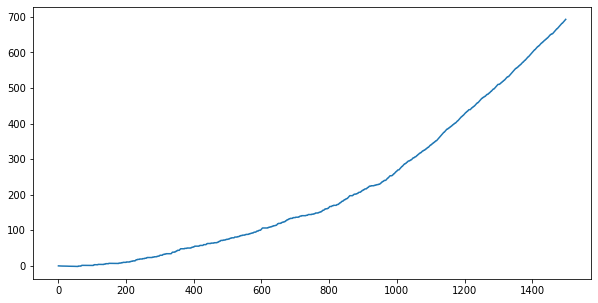

In [57]:
r = np.array(rewards_acum)
e = np.array(games_history)

plt.figure(figsize=(10,5))
plt.plot(e, r)
plt.show()



No handles with labels found to put in legend.


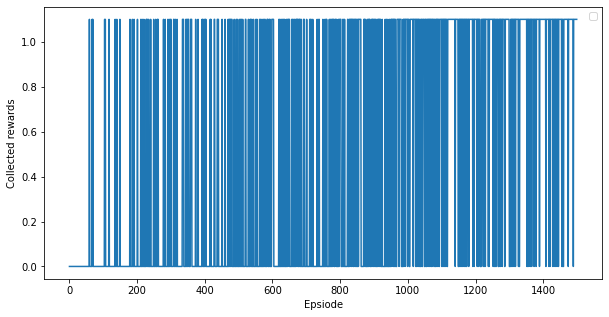

In [59]:
score_history = np.array(score_history)
plt.figure(figsize=(10,5))
plt.plot(score_history[:, 0], score_history[:, 1])
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.legend()
plt.show()


Let's to evaluate the policy with 500 episodes

In [90]:
total_score = 0
history_actions = []
for i in range (500):    
    print("nuevo episodio:", i)
    observation = env.reset()
    observation = to_onehot(num_inputs ,observation).reshape(1, num_inputs)
    env.render()
    score_epi = 0
    actions = []
    for _ in range(10):
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        observation_ = to_onehot(num_inputs ,observation_).reshape(1, num_inputs)
        observation = observation_
        actions.append(action)
        env.render()
        score_epi += reward        
        total_score += score_epi
        if done:                        
            break
    episode_actions = {'episode': i, 'reward': reward, 'actions': [actions]}    
    history_actions.append([episode_actions])
    print("Total Episode Score:", score_epi) 
    
    
print("Total Episodes Score:", total_score)


nuevo episodio: 0

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 1

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 2

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 3

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 4

SFFF
FHFH
FFFH
HF

  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 36

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 37

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 38

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Epi

  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 72

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 73

SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 0.0
nuevo episodio: 74

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 75

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (

  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 0.0
nuevo episodio: 112

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 113

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 114

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 0.0
nuevo episodio: 115

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 153

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 154

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 155

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 156

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 193

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 194

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 195

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 196

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 0.0
nuevo episodio: 197

SFFF
FHFH
F

  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 230

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 231

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 232

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 233

SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 257

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 0.0
nuevo episodio: 258

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 259

SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 0.0
nuevo episodio: 260

SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 0.0
nuevo episodio: 261

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 

  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 325

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 0.0
nuevo episodio: 326

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 327

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 328

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 329

SFFF
FHFH
FF

  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 364

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 365

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 366

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 367

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 403

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 404

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 405

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 406

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 444

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 445

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 446

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 447

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 480

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 481

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 482

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total Episode Score: 1.0
nuevo episodio: 483

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


In [91]:
history_actions

[[{'episode': 0, 'reward': 1.0, 'actions': [[1, 1, 2, 1, 2, 2]]}],
 [{'episode': 1, 'reward': 1.0, 'actions': [[1, 1, 2, 1, 2, 2]]}],
 [{'episode': 2, 'reward': 1.0, 'actions': [[1, 1, 2, 1, 2, 2]]}],
 [{'episode': 3, 'reward': 1.0, 'actions': [[1, 1, 2, 2, 1, 2]]}],
 [{'episode': 4, 'reward': 1.0, 'actions': [[1, 1, 2, 1, 2, 1, 2]]}],
 [{'episode': 5, 'reward': 1.0, 'actions': [[1, 1, 2, 1, 2, 1, 3, 1, 2]]}],
 [{'episode': 6, 'reward': 1.0, 'actions': [[1, 1, 2, 1, 2, 2]]}],
 [{'episode': 7, 'reward': 1.0, 'actions': [[1, 1, 2, 1, 2, 2]]}],
 [{'episode': 8, 'reward': 1.0, 'actions': [[1, 1, 2, 1, 2, 2]]}],
 [{'episode': 9, 'reward': 0.0, 'actions': [[1, 2]]}],
 [{'episode': 10, 'reward': 1.0, 'actions': [[1, 1, 2, 1, 2, 2]]}],
 [{'episode': 11, 'reward': 1.0, 'actions': [[1, 1, 2, 1, 2, 1, 2]]}],
 [{'episode': 12, 'reward': 1.0, 'actions': [[1, 1, 2, 1, 2, 1, 2]]}],
 [{'episode': 13, 'reward': 1.0, 'actions': [[1, 1, 2, 1, 2, 2]]}],
 [{'episode': 14, 'reward': 1.0, 'actions': [[1, 1, 

Let's to check the different trajectories done by the agent with reward 1.0 to check if there is exploration 

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

In [92]:
trajectories = []
stats = np.array(history_actions)
for i,j in enumerate(stats):
    if (j[0]['reward'] == 1.0):
        trajectories.append(j[0]['actions'])
        
values, counts = np.unique(trajectories, return_counts=True)
values, counts


(array([list([0, 1, 1, 2, 1, 2, 1, 2]), list([0, 1, 1, 2, 1, 2, 2]),
        list([1, 0, 1, 2, 1, 2, 1, 1, 2]), list([1, 0, 1, 2, 1, 2, 2]),
        list([1, 1, 0, 2, 1, 2, 2]), list([1, 1, 2, 0, 2, 1, 2, 1, 2]),
        list([1, 1, 2, 0, 2, 1, 2, 2]), list([1, 1, 2, 1, 1, 1, 2, 2]),
        list([1, 1, 2, 1, 1, 2, 1, 1, 2]), list([1, 1, 2, 1, 1, 2, 2]),
        list([1, 1, 2, 1, 2, 0, 2, 2]), list([1, 1, 2, 1, 2, 1, 0, 2, 2]),
        list([1, 1, 2, 1, 2, 1, 1, 1, 1, 2]),
        list([1, 1, 2, 1, 2, 1, 1, 1, 2]), list([1, 1, 2, 1, 2, 1, 1, 2]),
        list([1, 1, 2, 1, 2, 1, 2]), list([1, 1, 2, 1, 2, 1, 3, 1, 2]),
        list([1, 1, 2, 1, 2, 2]), list([1, 1, 2, 1, 3, 1, 2, 2]),
        list([1, 1, 2, 2, 0, 1, 2, 1, 2]),
        list([1, 1, 2, 2, 1, 1, 1, 1, 2]), list([1, 1, 2, 2, 1, 1, 2]),
        list([1, 1, 2, 2, 1, 2]), list([1, 1, 3, 1, 2, 1, 2, 2]),
        list([1, 3, 1, 1, 2, 1, 2, 2]), list([1, 3, 1, 1, 2, 2, 1, 2]),
        list([2, 2, 1, 1, 1, 2]), list([3, 1, 1, 2, 1, 2

In [ ]:
env.close()